# Churn Prediction Model

This notebook creates a machine learning model to predict user churn risk based on behavioral features.

**Churn Prediction Features:**
- `days_since_signup`: Days since user signed up
- `total_sessions`: Total number of sessions
- `avg_session_duration`: Average session duration (minutes)
- `streak_length`: Current streak length (days)
- `last_login_days_ago`: Days since last login
- `content_completion_rate`: Rate of content completion (0-1)
- `notification_response_rate`: Response rate to notifications (0-1)
- `goal_progress_percentage`: Progress towards goals (0-100)

The trained model will be saved as `churn_model.joblib` for use by the application.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to build churn prediction model...")

Libraries imported successfully!
Ready to build churn prediction model...


In [2]:
# Load the training dataset
data_path = "../data/training_dataset.csv"

if not os.path.exists(data_path):
    print("❌ Training dataset not found!")
    print("Please run the data_creation.ipynb notebook first to generate the dataset.")
else:
    df = pd.read_csv(data_path)
    print(f"✅ Loaded dataset with {len(df):,} users")
    print(f"Dataset shape: {df.shape}")
    print(f"Churn rate: {df['churn'].mean():.2%}")
    display(df.head())

✅ Loaded dataset with 2,000 users
Dataset shape: (2000, 14)
Churn rate: 36.00%


,user_id,user_type,session_count,avg_session_duration,streak_length,preferred_time_of_day,content_engagement_rate,notification_response_rate,days_since_signup,total_sessions,last_login_days_ago,content_completion_rate,goal_progress_percentage,churn
0,user_0000,active,21,17.558516,19,2,0.872892,0.738740,151,39,2,0.714521,90.316165,0
1,user_0001,active,22,15.810662,25,1,0.852700,0.875421,221,42,0,0.776061,78.366475,0
2,user_0002,active,15,14.297296,14,2,0.759624,0.814070,80,58,2,0.945808,76.336701,0
3,user_0003,active,21,10.046289,11,1,0.932110,0.886253,271,29,1,0.724418,83.948156,0
4,user_0004,active,21,15.319960,12,2,0.660678,0.656424,79,60,1,0.806289,67.277958,0


=== Churn Distribution Analysis ===
Active users (0): 1,280 (64.0%)
Churned users (1): 720 (36.0%)

Churn by user type:


,total_users,churned_users,churn_rate
user_type,,,
active,700,66,9.4%
low_engagement,600,435,72.5%
moderate,700,219,31.3%


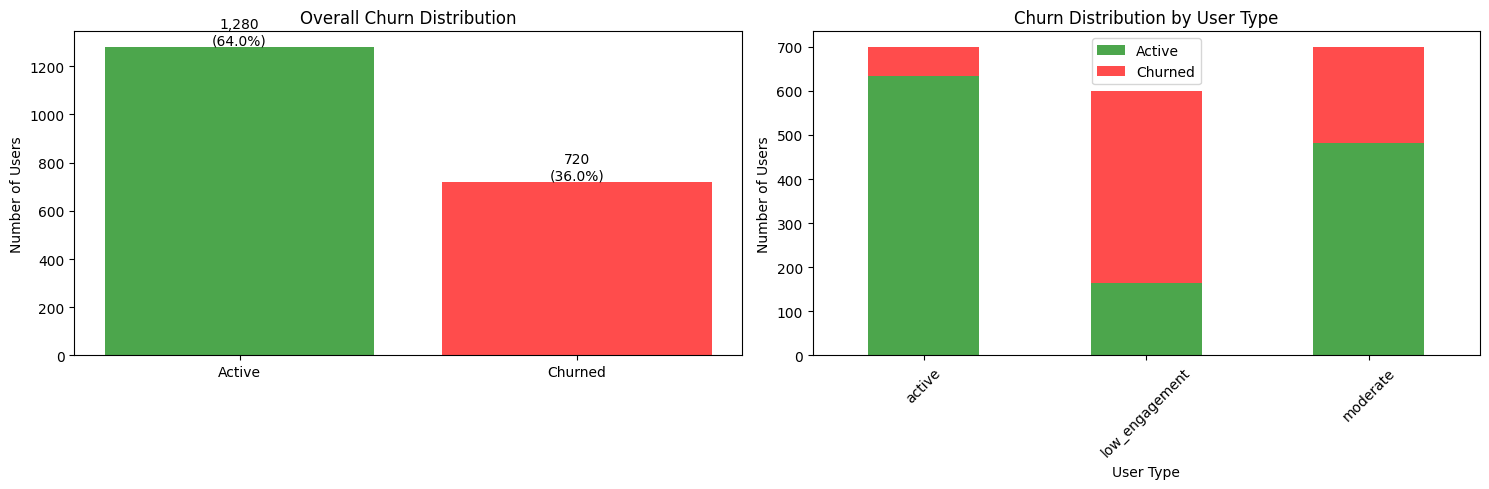

In [3]:
# Analyze churn distribution
print("=== Churn Distribution Analysis ===")

churn_counts = df['churn'].value_counts()
print(f"Active users (0): {churn_counts[0]:,} ({churn_counts[0]/len(df)*100:.1f}%)")
print(f"Churned users (1): {churn_counts[1]:,} ({churn_counts[1]/len(df)*100:.1f}%)")

# Churn by user type
print("\nChurn by user type:")
churn_by_type = df.groupby('user_type')['churn'].agg(['count', 'sum', 'mean'])
churn_by_type.columns = ['total_users', 'churned_users', 'churn_rate']
churn_by_type['churn_rate'] = churn_by_type['churn_rate'].apply(lambda x: f"{x:.1%}")
display(churn_by_type)

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall churn distribution
axes[0].bar(['Active', 'Churned'], churn_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Overall Churn Distribution')
axes[0].set_ylabel('Number of Users')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 10, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center')

# Churn by user type
user_type_churn = df.groupby(['user_type', 'churn']).size().unstack()
user_type_churn.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7, ax=axes[1])
axes[1].set_title('Churn Distribution by User Type')
axes[1].set_xlabel('User Type')
axes[1].set_ylabel('Number of Users')
axes[1].legend(['Active', 'Churned'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Prepare churn prediction features (exactly as defined in FeaturePreparator)
churn_features = [
    "days_since_signup",
    "total_sessions", 
    "avg_session_duration",
    "streak_length",
    "last_login_days_ago",
    "content_completion_rate",
    "notification_response_rate",
    "goal_progress_percentage"
]

X = df[churn_features].copy()
y = df['churn'].copy()

print("Churn prediction features:")
for i, feature in enumerate(churn_features, 1):
    print(f"  {i}. {feature}")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print("\nFeature statistics:")
display(X.describe())

Churn prediction features:
  1. days_since_signup
  2. total_sessions
  3. avg_session_duration
  4. streak_length
  5. last_login_days_ago
  6. content_completion_rate
  7. notification_response_rate
  8. goal_progress_percentage

Feature matrix shape: (2000, 8)
Target distribution: {0: 1280, 1: 720}

Feature statistics:


,days_since_signup,total_sessions,avg_session_duration,streak_length,last_login_days_ago,content_completion_rate,notification_response_rate,goal_progress_percentage
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,116.755500,25.270000,8.688296,7.934000,6.367000,0.571026,0.430955,49.013695
std,90.327572,18.558079,5.033791,8.172028,7.732736,0.224773,0.249685,26.127977
min,7.000000,1.000000,1.001665,0.000000,0.000000,0.100341,0.000127,0.013206
25%,48.000000,11.000000,4.593774,1.000000,1.000000,0.417083,0.223733,27.515660
50%,86.000000,20.000000,8.231628,5.000000,3.000000,0.554721,0.421661,48.868055
75%,159.000000,35.000000,11.760867,11.000000,8.000000,0.769633,0.623230,69.561613
max,363.000000,78.000000,19.978399,29.000000,29.000000,0.949886,0.898490,94.901382


Feature correlations with churn:
  content_completion_rate: -0.471 ↓
  notification_response_rate: -0.469 ↓
  goal_progress_percentage: -0.460 ↓
  avg_session_duration: -0.450 ↓
  last_login_days_ago: 0.435 ↑
  total_sessions: -0.401 ↓
  streak_length: -0.391 ↓
  days_since_signup: -0.341 ↓


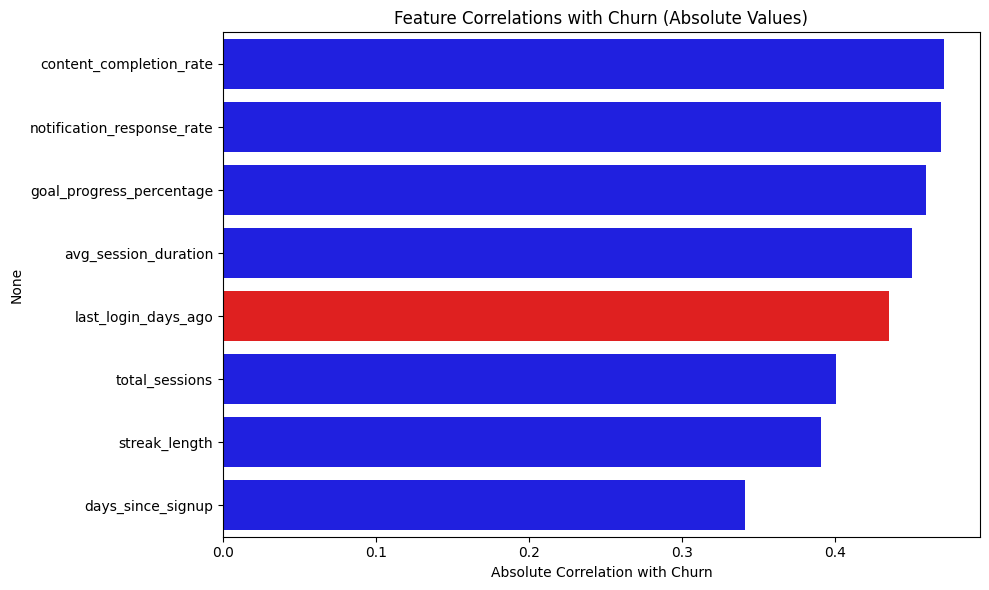

In [5]:
# Analyze feature correlations with churn
feature_churn_corr = df[churn_features + ['churn']].corr()['churn'].drop('churn').sort_values(key=abs, ascending=False)

print("Feature correlations with churn:")
for feature, corr in feature_churn_corr.items():
    direction = "↑" if corr > 0 else "↓"
    print(f"  {feature}: {corr:.3f} {direction}")

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_churn_corr.abs().values, y=feature_churn_corr.index, 
            palette=['red' if x > 0 else 'blue' for x in feature_churn_corr.values])
plt.title('Feature Correlations with Churn (Absolute Values)')
plt.xlabel('Absolute Correlation with Churn')
plt.tight_layout()
plt.show()

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled successfully")

Training set: 1,600 samples
Test set: 400 samples
Training churn rate: 36.00%
Test churn rate: 36.00%

✅ Features scaled successfully


In [7]:
# Train baseline Random Forest model
print("Training baseline Random Forest model...")

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_baseline.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = rf_baseline.predict(X_test_scaled)
y_pred_proba_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluate baseline model
print("\n=== Baseline Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Active', 'Churned']))

Training baseline Random Forest model...

=== Baseline Model Performance ===
Accuracy: 0.775
Precision: 0.711
Recall: 0.632
F1-Score: 0.669
ROC-AUC: 0.786

Classification Report:
              precision    recall  f1-score   support

      Active       0.81      0.86      0.83       256
     Churned       0.71      0.63      0.67       144

    accuracy                           0.78       400
   macro avg       0.76      0.74      0.75       400
weighted avg       0.77      0.78      0.77       400


=== Baseline Model Performance ===
Accuracy: 0.775
Precision: 0.711
Recall: 0.632
F1-Score: 0.669
ROC-AUC: 0.786

Classification Report:
              precision    recall  f1-score   support

      Active       0.81      0.86      0.83       256
     Churned       0.71      0.63      0.67       144

    accuracy                           0.78       400
   macro avg       0.76      0.74      0.75       400
weighted avg       0.77      0.78      0.77       400



In [8]:
# Hyperparameter tuning with GridSearchCV
print("Performing hyperparameter tuning...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_grid = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced'
)

grid_search = GridSearchCV(
    rf_grid, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.3f}")

# Train final model with best parameters
rf_final = grid_search.best_estimator_
y_pred_final = rf_final.predict(X_test_scaled)
y_pred_proba_final = rf_final.predict_proba(X_test_scaled)[:, 1]

Performing hyperparameter tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation ROC-AUC: 0.796

✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation ROC-AUC: 0.796


In [9]:
# Evaluate final model
print("=== Final Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Active', 'Churned']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix:")
print(cm)

# Cross-validation scores
cv_scores = cross_val_score(rf_final, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

=== Final Model Performance ===
Accuracy: 0.755
Precision: 0.660
Recall: 0.660
F1-Score: 0.660
ROC-AUC: 0.779

Classification Report:
              precision    recall  f1-score   support

      Active       0.81      0.81      0.81       256
     Churned       0.66      0.66      0.66       144

    accuracy                           0.76       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.76      0.76      0.76       400


Confusion Matrix:
[[207  49]
 [ 49  95]]

Cross-validation ROC-AUC: 0.796 (+/- 0.086)

Cross-validation ROC-AUC: 0.796 (+/- 0.086)


=== Feature Importance ===


,feature,importance
2,avg_session_duration,0.168507
7,goal_progress_percentage,0.164205
6,notification_response_rate,0.158427
5,content_completion_rate,0.157805
4,last_login_days_ago,0.096984
1,total_sessions,0.088799
0,days_since_signup,0.085492
3,streak_length,0.079781


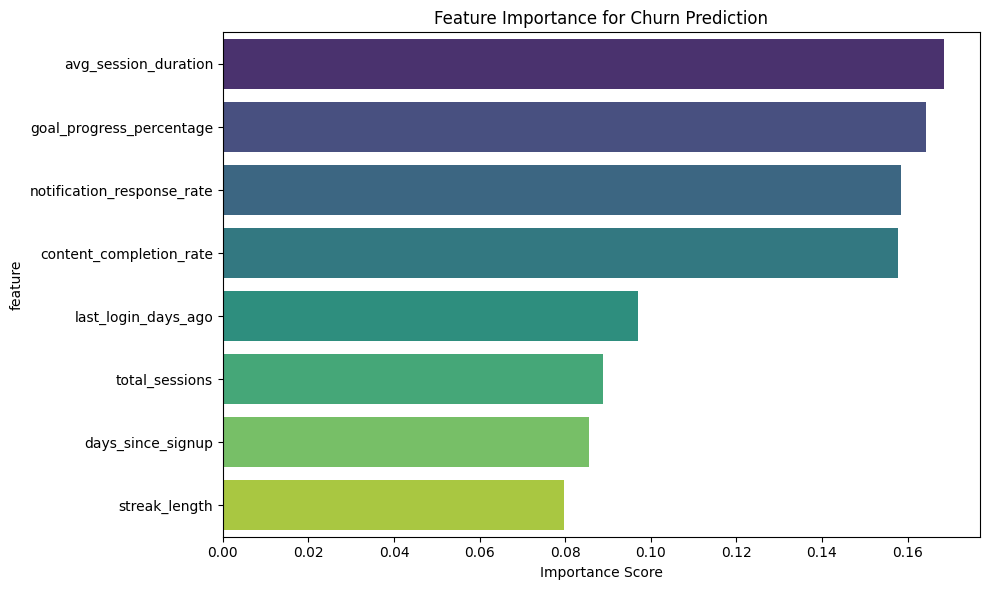


🏆 Top 3 Most Important Features:
  1. avg_session_duration: 0.169
  2. goal_progress_percentage: 0.164
  3. notification_response_rate: 0.158


In [10]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': churn_features,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Feature Importance ===")
display(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Top 3 most important features
top_features = feature_importance.head(3)
print(f"\n🏆 Top 3 Most Important Features:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.3f}")

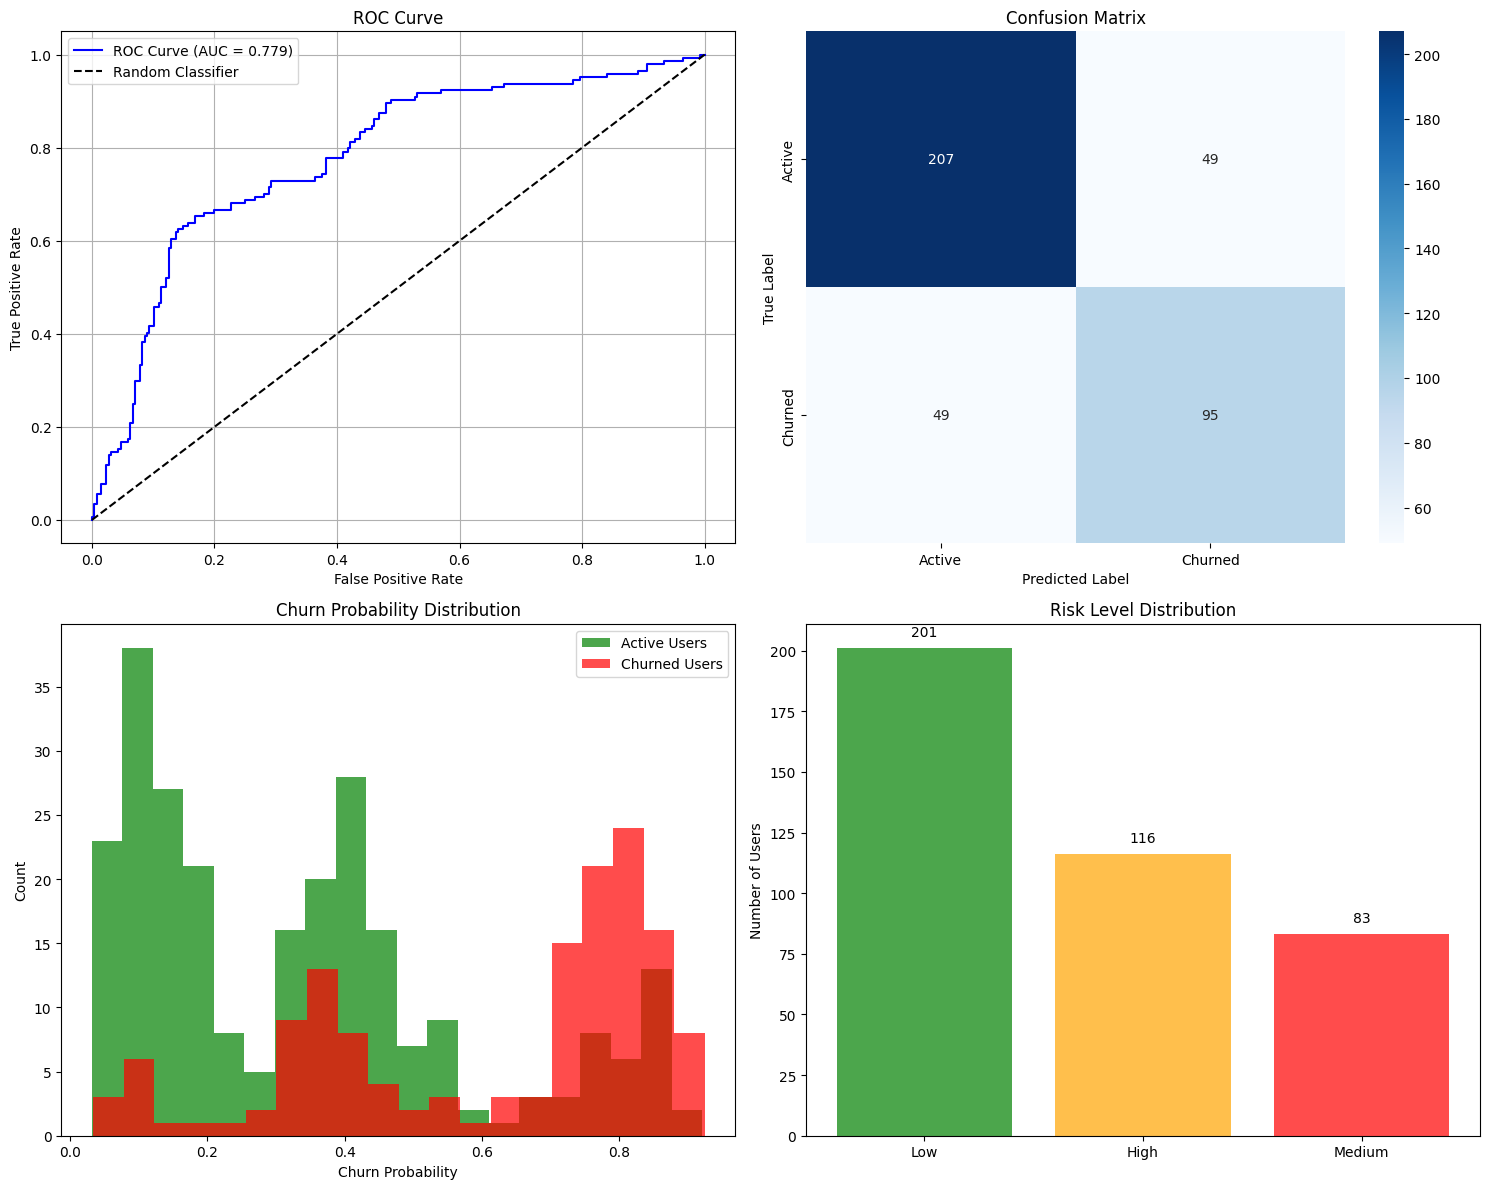

Risk level thresholds (matching application logic):
  • Low risk: < 0.4 churn probability
  • Medium risk: 0.4 - 0.7 churn probability
  • High risk: > 0.7 churn probability


In [11]:
# Model performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
auc_score = roc_auc_score(y_test, y_pred_proba_final)
axes[0,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='blue')
axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True)

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Churned'], 
            yticklabels=['Active', 'Churned'], ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_ylabel('True Label')
axes[0,1].set_xlabel('Predicted Label')

# 3. Prediction Probability Distribution
axes[1,0].hist(y_pred_proba_final[y_test==0], bins=20, alpha=0.7, label='Active Users', color='green')
axes[1,0].hist(y_pred_proba_final[y_test==1], bins=20, alpha=0.7, label='Churned Users', color='red')
axes[1,0].set_xlabel('Churn Probability')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Churn Probability Distribution')
axes[1,0].legend()

# 4. Risk Level Distribution (matching application logic)
risk_levels = []
for prob in y_pred_proba_final:
    if prob >= 0.7:
        risk_levels.append("High")
    elif prob >= 0.4:
        risk_levels.append("Medium")
    else:
        risk_levels.append("Low")

risk_counts = pd.Series(risk_levels).value_counts()
colors_risk = ['green', 'orange', 'red']
axes[1,1].bar(risk_counts.index, risk_counts.values, color=colors_risk, alpha=0.7)
axes[1,1].set_title('Risk Level Distribution')
axes[1,1].set_ylabel('Number of Users')
for i, v in enumerate(risk_counts.values):
    axes[1,1].text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

print("Risk level thresholds (matching application logic):")
print("  • Low risk: < 0.4 churn probability")
print("  • Medium risk: 0.4 - 0.7 churn probability") 
print("  • High risk: > 0.7 churn probability")

In [12]:
# Analyze model predictions by user type
df_test = df.loc[X_test.index].copy()
df_test['predicted_churn_prob'] = y_pred_proba_final
df_test['predicted_churn'] = y_pred_final

print("=== Model Performance by User Type ===")

for user_type in df_test['user_type'].unique():
    subset = df_test[df_test['user_type'] == user_type]
    actual_churn_rate = subset['churn'].mean()
    predicted_churn_rate = subset['predicted_churn'].mean()
    avg_churn_prob = subset['predicted_churn_prob'].mean()
    
    print(f"\n{user_type.title()} Users:")
    print(f"  Sample size: {len(subset):,}")
    print(f"  Actual churn rate: {actual_churn_rate:.1%}")
    print(f"  Predicted churn rate: {predicted_churn_rate:.1%}")
    print(f"  Average churn probability: {avg_churn_prob:.3f}")
    
    # Calculate accuracy for this user type
    accuracy = accuracy_score(subset['churn'], subset['predicted_churn'])
    print(f"  Accuracy: {accuracy:.3f}")

=== Model Performance by User Type ===

Moderate Users:
  Sample size: 143
  Actual churn rate: 29.4%
  Predicted churn rate: 11.2%
  Average churn probability: 0.400
  Accuracy: 0.664

Active Users:
  Sample size: 129
  Actual churn rate: 9.3%
  Predicted churn rate: 0.0%
  Average churn probability: 0.127
  Accuracy: 0.907

Low_Engagement Users:
  Sample size: 128
  Actual churn rate: 70.3%
  Predicted churn rate: 100.0%
  Average churn probability: 0.791
  Accuracy: 0.703


In [13]:
# Save the trained model and supporting data
ml_models_dir = "../ml_models/churn_classification"
os.makedirs(ml_models_dir, exist_ok=True)

# Save churn prediction model
churn_model_path = os.path.join(ml_models_dir, "churn_model.joblib")
joblib.dump(rf_final, churn_model_path)
print(f"✅ Saved churn model to {churn_model_path}")

# Save feature scaler
churn_scaler_path = os.path.join(ml_models_dir, "churn_scaler.joblib")
joblib.dump(scaler, churn_scaler_path)
print(f"✅ Saved feature scaler to {churn_scaler_path}")

# Save feature importance
feature_importance_path = os.path.join(ml_models_dir, "churn_feature_importance.csv")
feature_importance.to_csv(feature_importance_path, index=False)
print(f"✅ Saved feature importance to {feature_importance_path}")

# Save model metadata
model_metadata = {
    "model_type": "RandomForestClassifier",
    "feature_names": churn_features,
    "n_features": len(churn_features),
    "training_samples": len(X_train),
    "test_samples": len(X_test),
    "best_params": grid_search.best_params_,
    "performance_metrics": {
        "accuracy": float(accuracy_score(y_test, y_pred_final)),
        "precision": float(precision_score(y_test, y_pred_final)),
        "recall": float(recall_score(y_test, y_pred_final)),
        "f1_score": float(f1_score(y_test, y_pred_final)),
        "roc_auc": float(roc_auc_score(y_test, y_pred_proba_final))
    },
    "risk_thresholds": {
        "low": "< 0.4",
        "medium": "0.4 - 0.7",
        "high": "> 0.7"
    }
}

import json
metadata_path = os.path.join(ml_models_dir, "churn_model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Saved model metadata to {metadata_path}")

print(f"\n🎉 Churn prediction model training completed successfully!")
print(f"\n📁 Files created:")
print(f"   • {churn_model_path}")
print(f"   • {churn_scaler_path}")
print(f"   • {feature_importance_path}")
print(f"   • {metadata_path}")

print(f"\n📈 Final Model Performance:")
print(f"   • Algorithm: Random Forest with {rf_final.n_estimators} trees")
print(f"   • Features: {len(churn_features)} behavioral features")
print(f"   • Accuracy: {accuracy_score(y_test, y_pred_final):.3f}")
print(f"   • ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.3f}")
print(f"   • Training samples: {len(X_train):,} users")
print(f"   • Test samples: {len(X_test):,} users")

✅ Saved churn model to ../ml_models/churn_classification/churn_model.joblib
✅ Saved feature scaler to ../ml_models/churn_classification/churn_scaler.joblib
✅ Saved feature importance to ../ml_models/churn_classification/churn_feature_importance.csv
✅ Saved model metadata to ../ml_models/churn_classification/churn_model_metadata.json

🎉 Churn prediction model training completed successfully!

📁 Files created:
   • ../ml_models/churn_classification/churn_model.joblib
   • ../ml_models/churn_classification/churn_scaler.joblib
   • ../ml_models/churn_classification/churn_feature_importance.csv
   • ../ml_models/churn_classification/churn_model_metadata.json

📈 Final Model Performance:
   • Algorithm: Random Forest with 200 trees
   • Features: 8 behavioral features
   • Accuracy: 0.755
   • ROC-AUC: 0.779
   • Training samples: 1,600 users
   • Test samples: 400 users


In [14]:
# Test the saved model
print("=== Testing Saved Model ===")

# Load the model
loaded_churn_model = joblib.load(churn_model_path)
loaded_scaler = joblib.load(churn_scaler_path)
with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print("✅ All models and metadata loaded successfully")

# Test with sample user data (matching the expected API format)
test_users = [
    {
        "name": "High-risk user",
        "data": {
            "days_since_signup": 15,
            "total_sessions": 3,
            "avg_session_duration": 2.5,
            "streak_length": 0,
            "last_login_days_ago": 10,
            "content_completion_rate": 0.2,
            "notification_response_rate": 0.1,
            "goal_progress_percentage": 15.0
        }
    },
    {
        "name": "Low-risk user",
        "data": {
            "days_since_signup": 120,
            "total_sessions": 45,
            "avg_session_duration": 12.0,
            "streak_length": 15,
            "last_login_days_ago": 1,
            "content_completion_rate": 0.85,
            "notification_response_rate": 0.75,
            "goal_progress_percentage": 80.0
        }
    }
]

print(f"\n🧪 Testing with sample users:")

for test_user in test_users:
    # Prepare features (simulate FeaturePreparator logic)
    test_features = np.array([
        test_user["data"]["days_since_signup"],
        test_user["data"]["total_sessions"],
        test_user["data"]["avg_session_duration"],
        test_user["data"]["streak_length"],
        test_user["data"]["last_login_days_ago"],
        test_user["data"]["content_completion_rate"],
        test_user["data"]["notification_response_rate"],
        test_user["data"]["goal_progress_percentage"]
    ]).reshape(1, -1)
    
    # Scale features
    test_features_scaled = loaded_scaler.transform(test_features)
    
    # Make prediction
    churn_probability = loaded_churn_model.predict_proba(test_features_scaled)[0][1]
    
    # Determine risk level (matching application logic)
    if churn_probability >= 0.7:
        risk_level = "high"
    elif churn_probability >= 0.4:
        risk_level = "medium"
    else:
        risk_level = "low"
    
    print(f"\n{test_user['name']}:")
    print(f"  Churn probability: {churn_probability:.3f}")
    print(f"  Risk level: {risk_level}")
    print(f"  Input features: {test_user['data']}")

print(f"\n✅ Model is working correctly and ready for production use!")
print(f"\n🔧 Model compatible with:")
print(f"   • src/models/churn_model.py (ChurnPredictor)")
print(f"   • src/utils/feature_prep.py (FeaturePreparator)")
print(f"   • src/utils/model_loader.py (ModelLoader)")

=== Testing Saved Model ===
✅ All models and metadata loaded successfully

🧪 Testing with sample users:

High-risk user:
  Churn probability: 0.904
  Risk level: high
  Input features: {'days_since_signup': 15, 'total_sessions': 3, 'avg_session_duration': 2.5, 'streak_length': 0, 'last_login_days_ago': 10, 'content_completion_rate': 0.2, 'notification_response_rate': 0.1, 'goal_progress_percentage': 15.0}

Low-risk user:
  Churn probability: 0.065
  Risk level: low
  Input features: {'days_since_signup': 120, 'total_sessions': 45, 'avg_session_duration': 12.0, 'streak_length': 15, 'last_login_days_ago': 1, 'content_completion_rate': 0.85, 'notification_response_rate': 0.75, 'goal_progress_percentage': 80.0}

✅ Model is working correctly and ready for production use!

🔧 Model compatible with:
   • src/models/churn_model.py (ChurnPredictor)
   • src/utils/feature_prep.py (FeaturePreparator)
   • src/utils/model_loader.py (ModelLoader)
